# Purpose of this Notebook
- @AUTHOR: Kai Bernardini (kaidb@bu.edu)
- Give an overview of how the model functions, is built and optimized
- Benchmark on a **TOY** dataset

In [1]:
# Jupyter notebook specific 
from ipywidgets import interactive, fixed
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML   



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import math

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc,confusion_matrix

%matplotlib inline

In [54]:
%%bash
pip freeze > LR_requirements.txt

In [50]:
# Get the toy Dataset 
def find(name, path): #Helper method for locating files
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
path =  find('Wisconsin_breast_cancer.csv', "./" )
path

'./Wisconsin_breast_cancer.csv'

In [21]:
# Display the first 5 rows of the dataset
data = pd.read_csv(path, index_col=0)
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Target
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,0.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,0.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,0.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0


In [22]:
# Some Preprocessing 
features = data.columns.values[:-1]
target = data.columns.values[-1]

# 0 -- Benign
# 1 -- Malignant
target_map = {
    'benign':0,
    'malignant':1
}

X, Y = data[features], data[target]
Y = Y.values.reshape((Y.shape[0],1))

# Sigmoid Squashing Function 

$h(x) = g( X w + b)$
for $X \in \mathbb{R}^{m \times p }$ ( $m$ examples, $p$ predictors) and $w \in \mathbb{R}^p$

where function g is the sigmoid function. The sigmoid function is defined as:

$g(z) = \dfrac{1}{1+e^{-z}}$


In [3]:
def g(z):
    """
    This function computes the sigmoid function across all values of z

    Argument:
    z -- numpy array of real numbers

    Returns:
    sigmoid(z)
    """
    
    return 1 / (1 + np.exp(-z))

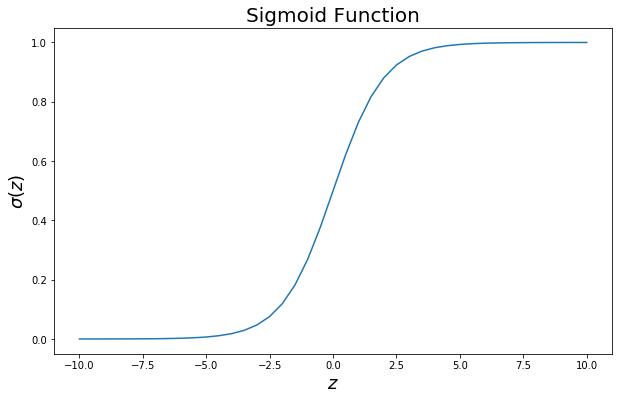

In [15]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(-10,10.5,.5) ,g( np.arange(-10,10.5,.5)))
plt.xlabel('$z$',fontsize=18)
plt.ylabel('$\sigma(z)$',fontsize=18)
#plt.bac
#plt.grid(True)
plt.title("Sigmoid Function", fontsize=20)
plt.savefig('sigmoid.png', transparent=True)
#plt.savefig("sigmoid.png")

# Logistic Regression
- Logistic regression is a way of adapting linear regression to a situation where the dependent variable Y (the outcome) has only two values, 0 or 1.
- General Assumptions:
$$P(\ y=1 \; \vert \; x \ ; \ b,w \ ) = h_{w,b}(x)$$ 

$$P(\ y=0 \; \vert \; x \ ; \ b,w \ ) = 1 - h_{b,w}(x)$$



In [25]:
def h(b, w ,X):
    """
    This function implments the logistic regression hypothesis function

    Argument:
    b -- bias
    w -- predictive parameters
    X -- data matrix of size (numbers_examples, number_predictors)

    Returns:
    sigmoid(Xw + b)
    """
    return g( (X @ w) + b)

# Loss Function
- Goal is to maximize the likelihood of observations

$$L(\theta) = \prod_{i=1}^{m}{h_{b,w}(x^i)}^{y^{(i)}}(1-h_{b,w}(x^i))^{1-y^{(i)}}$$

Taking the log of both sides gives

$$\log L(b,w) =\sum_{i=1}^{m} \ [ \ -y^{(i)} \log(h_{b,w}(x^{(i)})) \ - \ (1 - y^{(i)})\log(1-h_{b,w}(x^{(i)}))$$

- Goal is is to find 
$$ \hat{b}, \hat{w} = min_{b,w} J(w,b,X,Y) = min_{b,w}\sum_{i=1}^{m} \ [ \ -y^{(i)} \log(h_{b,w}(x^{(i)})) \ - \ (1 - y^{(i)})\log(1-h_{b,w}(x^{(i)}))$$

In [26]:
def computeCost(b, w, X, Y, lmbda = 0): 
    """
    Computes Cross Entropy Loss function 

    Arguments:
    b -- bias
    w -- predictive parameters
    X -- data matrix of size (numbers_examples, number_predictors)
    Y -- Ground truth labels of size (number_examples, 1)
    lmbda -- regularization hyperparameter
    
    Return:
    cost -- negative log-likelihood cost for logistic regression
    """

    m = Y.size
    term1 = np.dot(-np.array(Y).T,np.log(h(b,w,X)))
    term2 = np.dot((1-np.array(Y)).T,np.log(1-h(b,w,X)))
    reg = (1/2)* lmbda * w.T @ w
    return np.squeeze( (1./m) * ( np.sum(term1 - term2) )  + reg)

# Optimization
- There is no closed form solution to the above optimization problem, so we resort to numerical methods.
## Gradient Decent 
- Choose a learning rate $\alpha$ 
- for $k$ iterations, do the following:
    - $$w \leftarrow w - \alpha (\nabla_w J)$$
    - $$b \leftarrow b - \alpha (\frac{\partial }{\partial b}J)$$

In [27]:

def computeGradients(b, w, X, Y, lmbda):
    """
    Computes gradients

    Arguments:
    b -- bias
    w -- weight parameters
    X -- datamatrix
    Y -- ground truth labels 
    lmbda -- regularization hyperparameter

    Return:
    cost -- Loss function cose
    dw -- gradient of the loss with respect to predictors w
    db -- gradient of the loss with respect to bias b    
    """
    # number of examples
    m = X.shape[0]
    # Hypothesis predictions 
    hx = h(b,w,X)
    cost = computeCost(b, w, X,Y)
    dw =  (1/m ) *  X.T @ (hx -Y) + (lmbda * w) 
    db = (1/m ) *  np.sum(hx - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    # Cost should be scalar
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    # store cost to track its value as a function of iterations 
    return grads, cost

In [28]:
# Util function for utiling weights 
def initialize(p):
    """
    This function initializes the predictive parameters to all 0. 

    Argument:
    p -- Number of predictors 

    Returns:
    w -- Zero vector of shape (p, 1) (column vector)
    b -- bias (initialized to 0) (scalar)
    """
    
    w = np.zeros((p,1))
    b = 0.

    # Ensure the model corectly initializes all parameters 
    assert(w.shape == (p, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    return  b, w

In [29]:
# Python implementation of gradient descent with early stoping 
def gradientDescent(b, w,  X, Y,lmbda, num_iterations, learning_rate, verbose = False, stopping_tolerance = 1e-8):
    """
    This function calculates w,b  by running a gradient descent for num_iterations. 
    
    Arguments:
    b -- bias, 
    w -- predictors
    X -- datamatrix
    Y -- ground truth labels
    lmbda -- regularization hyperparameter
    num_iterations -- number of times to run GD 
    learning_rate -- values for alpha. 
    verbose --Log the loss every 100 steps
    
    Returns:
    b_optimal -- optimized bias 
    w_optimal -- optimized predictor
    costs -- Array of 
    
    TODO: add early stoping, optimization options, regularization 
    """
    
    costs = []
    tol=0
    for i in range(num_iterations):
        # Compute Gradient and cost
        grads, cost = computeGradients(b, w, X, Y, lmbda)
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Gradient update
        w_old = w
        b_old = b
        
        w = w - learning_rate * (dw)
        b = b - learning_rate * (db)
        if np.linalg.norm(w_old - w) < stopping_tolerance:
            tol+=1
            if tol>10:
                print("Early stopping triggered at itteration {}".format(i))
                costs.append(cost)
                break
        else:
            tol=0
        # Log cost (every 100 iterations )
        if i % 100 == 0:
            costs.append(cost)
            if verbose:
                print ("Loss Value after iteration {}: {}".format(i, cost))
    
    b_optimal, w_optimal = b, w
    return b_optimal, w_optimal, costs

# Gradient Descent with Momentum
- Similar, but uses an exponential rolling average 
- Also introduces a parameter velocity $v$ (dependent on params). 
- Updates rules are defined as follows:
$$ \begin{cases}
v_{dw} = \beta v_{dw} + (1 - \beta) dw \\
w = w- \alpha v_{dw}
\end{cases}$$

$$\begin{cases}
v_{db} = \beta v_{db} + (1 - \beta) db \\
b = b - \alpha v_{db} 
\end{cases}$$

where  $\beta$ is the momentum and $\alpha$ is the learning rate.[hyper parameters]

In [30]:
def initialize_velocity(b,w):
    """
    Initializes the velocity for momentum
    
    Arguments:
    b -- bias 
    w -- predictive parameters 
    
    Returns:
    v -- python dictionary containing velocity
    """
    v  = {}
    v["dw"] = np.zeros( w.shape)
    v["db"] = np.zeros( (1,1))
    return v

In [31]:
def compute_update_with_momentum(b,w, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    b -- bias
    w -- predictive weights
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    # Momentum update for each parameter
    dw, db = grads["dw"], grads["db" ]
    vdw, vdb = v["dw"], v["db"]
    # compute velocities
    v["dw"] = (beta * vdw) + (1 - beta)*dw
    v["db"] = (beta * vdb) + (1 - beta)*db
    # update parameters
    w -= learning_rate * v["dw"]
    b -= learning_rate * v["db"]

    return b,w, v

In [32]:

def momentumGradientDescent(b, w,v,  X, Y,lmbda, num_iterations, learning_rate,beta, verbose = False, stopping_tolerance = 1e-6):
    """
    This function calculates w,b  by running a gradient descent for num_iterations. 
    
    Arguments:
    b -- bias, 
    w -- predictors
    v -- velocity parameters 
    X -- datamatrix
    Y -- ground truth labels
    lmbda -- regularization hyperparameter
    num_iterations -- number of times to run GD 
    learning_rate -- values for alpha. 
    beta -- momentum
    verbose --Log the loss every 100 steps
    
    Returns:
    b_optimal -- optimized bias 
    w_optimal -- optimized predictor
    costs -- Array of 
    
    TODO: add early stoping, optimization options, regularization 
    """
    
    costs = []
    tol=0
    for i in range(num_iterations):
        # Compute Gradient and cost
        grads, cost = computeGradients(b, w, X, Y, lmbda)
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # Gradient update
        w_old = w
        b_old = b
        b,w,v = compute_update_with_momentum(b,w, grads, v, beta, learning_rate)
    
        if np.linalg.norm(w_old - w) < stopping_tolerance:
            tol+=1
            if tol>1000:
                print("Early stopping triggered at itteration {}".format(i))
                costs.append(cost)
                break
        else:
            tol=0
        # Log cost (every 100 iterations )
        if i % 1000 == 0:
            costs.append(cost)
            if verbose:
                print ("Loss Value after iteration {}: {}".format(i, cost))
    
    b_optimal, w_optimal = b, w
    return b_optimal, w_optimal, costs

# Stochastic/ Mini-batch   Gradient Descent
- Update parameters in chunks
- Learning plot is no longer Monotone

In [33]:
# initialize batches.

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 69): 
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- Datamatrix of shape (m,p) (m examples, p predictors)
    Y -- Ground Truth vector of shape (m,1)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of tuples (mini_batch_X_i, mini_batch_Y_i) for i =0...len(mini_batches)-1
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Permute the dataset synchronously 
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[ permutation,:].reshape((m,1))

    # Divide (X,Y) into chunks of mini_batch_size
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[ k * mini_batch_size : (k+1) * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[ k * mini_batch_size : (k+1) * mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Edge Case
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[ num_complete_minibatches*mini_batch_size:: ,:]
        mini_batch_Y = shuffled_Y[ num_complete_minibatches*mini_batch_size:: ,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [34]:

def miniBatchMomentumGradientDescent(b, w,v,  X, Y,lmbda, num_iterations, learning_rate,beta, verbose = False,batch_size=64,seed=6969, stopping_tolerance = 1e-6):
    """
    This function calculates w,b  by running a gradient descent for num_iterations. 
    
    Arguments:
    b -- bias, 
    w -- predictors
    v -- velocity parameters 
    X -- datamatrix
    Y -- ground truth labels
    lmbda -- regularization hyperparameter
    num_iterations -- number of times to run GD 
    learning_rate -- values for alpha. 
    beta -- momentum
    verbose --Log the loss every 100 steps
    
    Returns:
    b_optimal -- optimized bias 
    w_optimal -- optimized predictor
    costs -- Array of 
    
    TODO: add early stoping, optimization options, regularization 
    """
    
    costs = []
    for i in range(num_iterations):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, batch_size, seed)
        
        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch
            # Compute Gradient and cost
            grads, cost = computeGradients(b, w, minibatch_X, minibatch_Y, lmbda)
            # Retrieve derivatives from grads
            dw = grads["dw"]
            db = grads["db"]

            # Gradient update
            w_old = w
            b_old = b
            b,w,v = compute_update_with_momentum(b,w, grads, v, beta, learning_rate)

           
            # Log cost (every 100 iterations )
            if i % 1000 == 0:
                costs.append(cost)
                if verbose:
                    print ("Loss Value after iteration {}: {}".format(i, cost))

    b_optimal, w_optimal = b, w
    return b_optimal, w_optimal, costs

In [35]:

# A solution

class LogisticRegression:
    def __init__(self, lmbda = 0, learning_rate = .01,beta=.9 ,num_iterations= 10000, opt='GD', seed=6969, batch_size=64):
        self.costs = None
        self.opt=opt
        self.lmbda = lmbda
        self.alpha = learning_rate
        # only used if momentum is used 
        self.beta=.9
        self.num_iterations = num_iterations
        self.seed = seed
        self.batch_size = batch_size
        
    def fit(self, X, Y, verbose=False):
        self.p = X.shape[1]
        self.b, self.w = initialize(self.p)
        opt=self.opt
        if opt =="GD":
            print("Using Gradient Descent")
            self.b,self.w , self.costs = gradientDescent(
                self.b, 
                self.w,
                X,
                Y,
                self.lmbda,
                self.num_iterations,
                self.alpha,
                verbose = verbose)
        if opt == "Momentum":
            print("Using Gradient Descent with Momentum")
            self.v = initialize_velocity(self.b,self.w)
            self.b,self.w , self.costs = momentumGradientDescent(
                self.b, 
                self.w,
                self.v,
                X,
                Y,
                self.lmbda,
                self.num_iterations,
                self.alpha,
                self.beta,
                verbose = verbose)
        if opt == "MB_Momentum":
            print("Using MiniBatch Gradient Descent with Momentum")
            self.v = initialize_velocity(self.b,self.w)
            self.b,self.w , self.costs = miniBatchMomentumGradientDescent(
                b=self.b, 
                w= self.w,
                v= self.v,
                X=X,
                Y=Y,
                lmbda = self.lmbda,
                num_iterations= self.num_iterations,
                learning_rate= self.alpha,
                beta= self.beta,
                batch_size= self.batch_size,
                seed = self.seed,
                verbose = verbose)
            

        
    def predict_prob(self, X):
        return h(self.b, self.w, X)
    
    def predict(self, X):
        preds = self.predict_prob(X)
        return np.around(preds + 1e-6) 
    
    def score(self, X, Y):
        preds = self.predict(X)
        return np.squeeze(np.sum(preds == Y) / len(Y))
    
    def plot_learning_curve(self):
        # Plot learning curve (with costs)
        plt.figure(figsize=(8,6))
        plt.plot(self.costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(self.alpha))
        plt.show()
        
    

In [36]:
clf = LogisticRegression(lmbda=10, opt="MB_Momentum")
clf.fit(X.values,Y, verbose=True)

Using MiniBatch Gradient Descent with Momentum
Loss Value after iteration 0: 0.6931471805599452
Loss Value after iteration 0: 0.6883580635813772
Loss Value after iteration 0: 0.6880002762386226
Loss Value after iteration 0: 0.6802203515592435
Loss Value after iteration 0: 0.6701431064481422
Loss Value after iteration 0: 0.6578621746099108
Loss Value after iteration 0: 0.6692042042449033
Loss Value after iteration 0: 0.6574985351596642
Loss Value after iteration 0: 0.6399569202111633
Loss Value after iteration 0: 0.6639779134070919
Loss Value after iteration 0: 0.6340404882785461
Loss Value after iteration 1000: 0.34121058234538687
Loss Value after iteration 1000: 0.29189592080573845
Loss Value after iteration 1000: 0.2900983958861779
Loss Value after iteration 1000: 0.28759349084809066
Loss Value after iteration 1000: 0.32091549741264835
Loss Value after iteration 1000: 0.33864834131004723
Loss Value after iteration 1000: 0.3390595873135183
Loss Value after iteration 1000: 0.2829876328

In [37]:
clf.score(X,Y)

0.931185944363104

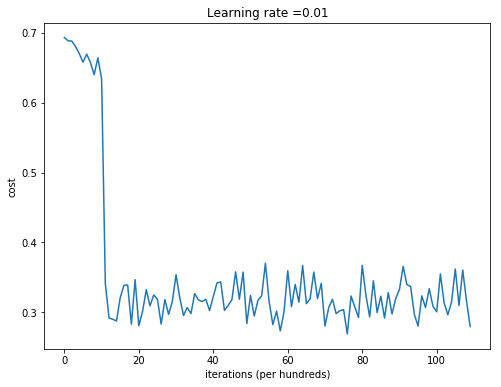

In [39]:
clf.plot_learning_curve()

In [40]:
prob_preds = clf.predict_prob(X)
fpr, tpr, thresholds = roc_curve(Y, prob_preds)

In [41]:
len(thresholds)

108

In [42]:
AUC = auc(fpr,tpr)
#f1_score(Y, preds)


In [43]:
def max_f1(prob_preds, labels):
    """
    Finds the threshold of classification that maximizes the F1 Metric
    
    Arguments: 
    prob_preds -- numpy array of probability scores 
    labels -- ground truth labels
    
    Return:
    cutoff -- Cutoff that maximizes the F1 metric
    max_f1 -- maximal value for the f1 metric
    """
    cutoff = 0
    max_f1 = 0
    for i in prob_preds:
        preds = prob_preds > i
        tmp_score = f1_score(labels, preds)
        if tmp_score > max_f1:
            max_f1 = tmp_score
            cutoff = i
    return cutoff, max_f1

In [44]:
def find_closest_index(cutoff, thresholds):
    """
    Finds the threshold closest to the cutoff. 
    
    Arguments:
    cutoff -- scalar cutoff value
    threshholds -- list of all unique probabilities 
    TODO: implement this using Binary Search 
    
    Return:
    best_index -- index of thresholds that has a value closest to cutoff
    TODO: Implement with binary search. 
    """
    best_index = -1
    min_dist = 9999999
    for i in range(len(thresholds)):
        tmp = abs(cutoff - thresholds[i])
        if tmp < min_dist:
            min_dist = tmp
            best_index = i
    return best_index

In [45]:
cm_cols = ["Predicited Benign", "Predicted Malignant"]
cm_index = ["Benign", "Malignant"]

def plot_roc(cutoff):
    cutoff_index = find_closest_index(cutoff, thresholds)
    print("Closest threshold is", thresholds[cutoff_index])
    print("For threshold of: " ,thresholds[cutoff_index], 'FPR:', fpr[cutoff_index], "TPR:", tpr[cutoff_index])
    fig = plt.figure(figsize=(8,8))
    plt.plot(fpr,tpr)
    plt.title("ROC curve with AUC={}".format(AUC))
    plt.plot([0,1],'r--') 
    plt.scatter(fpr[cutoff_index],tpr[cutoff_index], marker='x',s=200, c='r')
    preds = np.array(prob_preds) >= cutoff
    preds = preds.astype(int)
    cm = confusion_matrix(Y, preds)
    f1 = f1_score(Y, preds)
    cm_df = pd.DataFrame(cm, index=cm_index, columns=cm_cols)
    print('F1-score',f1)
    print()
    print(cm_df)
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")
    
interactive(plot_roc, cutoff=(0.,1.))

A Jupyter Widget

/Users/kbernardini/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Closest threshold is 0.2928278003047412
For threshold of:  0.2928278003047412 FPR: 0.033783783783783786 TPR: 0.99581589958159
F1-score 0.9655172413793104

           Predicited Benign  Predicted Malignant
Benign                   428                   16
Malignant                  1                  238


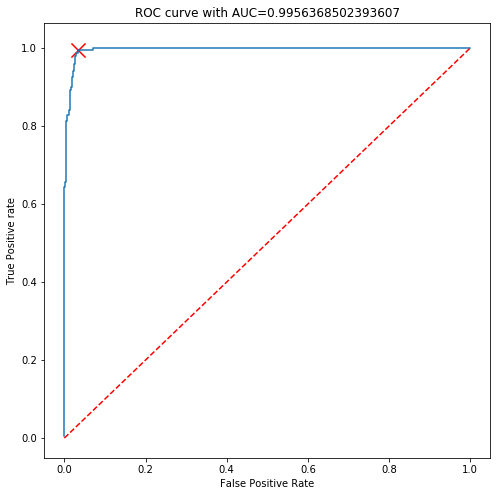

In [47]:
plot_roc(max_f1(prob_preds, Y)[0])